In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os


from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [35]:
!pwd
#data_folder_path = './data/'
data_folder_path = '/content/drive/MyDrive/toxic-comment-classification/data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

/content


In [36]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

In [6]:
'''
toxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]
non_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]

replacement_rate =0.3
##  synonym replacement
aug_toxic_df = toxic_df.copy(True)
for i, row in toxic_df.iterrows():
    comment = row['comment_text']
    words = comment.split()
    new_comment = ''
    new_words = []
    for word in words:
        if word in stopwords.words('english'):
            new_words.append(word)
            continue

        random_rate = np.random.uniform(0, 1)

        if random_rate < replacement_rate:
            synonyms = []
            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
            if len(synonyms) > 0:
                new_word = synonyms[np.random.randint(0, len(synonyms))]
                new_words.append(new_word)
            else:
                new_words.append(word)


        else:
            new_words.append(word)
    new_comment = ' '.join(new_words)
    new_row = row.copy(True)
    new_row['comment_text'] = new_comment
    aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
    
df = pd.concat([aug_toxic_df, non_toxic_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
'''

"\ntoxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]\nnon_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]\n\nreplacement_rate =0.3\n##  synonym replacement\naug_toxic_df = toxic_df.copy(True)\nfor i, row in toxic_df.iterrows():\n    comment = row['comment_text']\n    words = comment.split()\n    new_comment = ''\n    new_words = []\n    for word in words:\n        if word in stopwords.words('english'):\n            new_words.append(word)\n            continue\n\n        random_rate = np.random.uniform(0, 1)\n\n        if random_rate < replacement_rate:\n            synonyms = []\n            for syn in wordnet.synsets(word):\n                for l in syn.lemmas():\n                    synonyms.append(l.name())\n            if len(synonyms) > 0:\n                new_word =

In [37]:
test_df[0:20]
ids_to_drop = []
for i in range(len(test_df)):
    if test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1:
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)

test_df.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding I think very highl...,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" It says it even in Binghamton Universit...",0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,""" == Before adding a new product to the l...",00059ace3e3e9a53,0,0,0,0,0,0


In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [9]:
from torchtext.vocab import GloVe, vocab

unk_token = "<pad>"
unk_index = 0
#name = "vector_cache"


if os.path.isdir("/content/drive/MyDrive/toxic-comment-classification/.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


./.vector_cache/glove.twitter.27B.zip: 1.52GB [04:45, 5.33MB/s]                            
100%|█████████▉| 1193513/1193514 [01:13<00:00, 16334.11it/s]


1193514
torch.Size([1193515, 200])


In [10]:
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_frame,
        sequence_length,
    ):
        #self.args = args
        self.sequence_length = sequence_length
        self.train_df = data_frame
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]
    
    def load_words(self):
        #train_df = pd.read_csv('data/reddit-cleanjokes.csv')
        text = self.train_df['comment_text'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

In [11]:
dataset = Dataset(df, 3)

In [12]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
    
    def forward(self, x, prev_state):
      embed = self.embedding(x)
      output, state = self.lstm(embed, prev_state)
      logits = self.fc(output)
      return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))


In [13]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

def train(dataset, model):
    model.train()

    dataloader = DataLoader(dataset, batch_size=256)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(2):
        state_h, state_c = model.init_state(3)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [14]:


model = Model(dataset)

train(dataset, model)
#print(predict(dataset, model, text='Knock knock. Whos there?'))

{'epoch': 0, 'batch': 0, 'loss': 12.532023429870605}
{'epoch': 0, 'batch': 1, 'loss': 12.525912284851074}
{'epoch': 0, 'batch': 2, 'loss': 12.510509490966797}
{'epoch': 0, 'batch': 3, 'loss': 12.495269775390625}
{'epoch': 0, 'batch': 4, 'loss': 12.481305122375488}
{'epoch': 0, 'batch': 5, 'loss': 12.48913860321045}
{'epoch': 0, 'batch': 6, 'loss': 12.459647178649902}
{'epoch': 0, 'batch': 7, 'loss': 12.404488563537598}
{'epoch': 0, 'batch': 8, 'loss': 12.3687162399292}
{'epoch': 0, 'batch': 9, 'loss': 12.299186706542969}
{'epoch': 0, 'batch': 10, 'loss': 12.16001033782959}
{'epoch': 0, 'batch': 11, 'loss': 11.890575408935547}
{'epoch': 0, 'batch': 12, 'loss': 11.862200736999512}
{'epoch': 0, 'batch': 13, 'loss': 11.611714363098145}
{'epoch': 0, 'batch': 14, 'loss': 11.305839538574219}
{'epoch': 0, 'batch': 15, 'loss': 11.272300720214844}
{'epoch': 0, 'batch': 16, 'loss': 9.589383125305176}
{'epoch': 0, 'batch': 17, 'loss': 6.73863410949707}
{'epoch': 0, 'batch': 18, 'loss': 6.483482360

KeyboardInterrupt: ignored

In [23]:
torch.save(model.state_dict(), '/content/drive/MyDrive/toxic-comment-classification/Words_generation_model.pkl')

In [24]:
model_gen = Model(dataset)
model_gen.load_state_dict(torch.load('/content/drive/MyDrive/toxic-comment-classification/Words_generation_model.pkl'))

<All keys matched successfully>

In [16]:
def predict(dataset, model, text, next_words=10):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

In [34]:
print(predict(dataset, model, text='no no no no'))

['no', 'no', 'no', 'no', 'Romanes', 'purpureus', 'unfounded?', 'have', 'proceed', 'you', 'been', 'test', 'your', 'discussing']


In [45]:
df_len = len(df)
for a in range(0 , df_len):
    print(str(a) + "/" + str(df_len))
    if (df.iloc[a]['toxic'] == 1) | (df.iloc[a]['severe_toxic'] == 1) | (df.iloc[a]['obscene'] == 1) | (df.iloc[a]['threat'] == 1) | (df.iloc[a]['insult'] == 1) | (df.iloc[a]['identity_hate'] == 1):  
      f = df["comment_text"][a]
      following_words = predict(dataset, model, text=f)
      sentence = ' '.join(following_words)
      df["comment_text"][a] = sentence
    

0/159571
1/159571
2/159571
3/159571
4/159571
5/159571
6/159571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


7/159571
8/159571
9/159571
10/159571
11/159571
12/159571
13/159571
14/159571
15/159571
16/159571
17/159571
18/159571
19/159571
20/159571
21/159571
22/159571
23/159571
24/159571
25/159571
26/159571
27/159571
28/159571
29/159571
30/159571
31/159571
32/159571
33/159571
34/159571
35/159571
36/159571
37/159571
38/159571
39/159571
40/159571
41/159571
42/159571


KeyboardInterrupt: ignored

In [46]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")



class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:

            tokens = [self.pad_token] * diff + tokens
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [47]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)

In [25]:
print(df['comment_text'].values)

["Explanation  Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now"
 "D'aww! He matches this background colour I'm seemingly stuck with Thanks  (talk) :, January ,  (UTC)"
 "Hey man, I'm really not trying to edit war It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info"
 ...
 'Spitzer     Umm, theres no actual article for prostitution ring  - Crunch Captain'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it'
 '"  And  I came here and my idea was bad right away  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them   "']


In [48]:
MAX_LEN

265

In [14]:
for data in test_dataset:
    print(data['text'])
    print(data['labels'])
    print(data['indices'])
    break

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

In [49]:
postive_num = [0, 0, 0, 0, 0, 0]
negative_num = [0, 0, 0, 0, 0, 0]
for data in train_dataset:
    class_num = 0
    for i in data['labels'].tolist():
      if i == 0:
        negative_num[class_num] += 1
      else:
        postive_num[class_num] += 1
      class_num += 1


In [50]:
print(postive_num)
print(negative_num)

[15294, 1595, 8449, 478, 7877, 1405]
[144277, 157976, 151122, 159093, 151694, 158166]


In [ ]:
'''
import numpy as np

neg_weight_set = (1 - 0.9999) / (1 - np.power(0.9999, negative_num))
pos_weight_set = (1 - 0.9999) / (1 - np.power(0.9999, postive_num))
#weight_set = neg_weight_set / pos_weight_set
weight_set = np.sqrt(negative_num / postive_num)
print("weight_set: ", weight_set)
print(neg_weight_set)
print(pos_weight_set)
'''

In [51]:
import numpy as np

pos_weight_set = [0, 0, 0, 0, 0, 0]
neg_weight_set = [0, 0, 0, 0, 0, 0]
weight_set = [0, 0, 0, 0, 0, 0]
weight_set_sqrt = [0, 0, 0, 0, 0, 0]
for num in range(len(postive_num)):
  #weight_set[num] = negative_num[num] / postive_num[num]
  pos_weight_set[num] = (1 - 0.9999) / (1 - np.power(0.9999, postive_num[num]))
  neg_weight_set[num] = (1 - 0.9999) / (1 - np.power(0.9999, negative_num[num]))
  weight_set[num] =  pos_weight_set[num] / neg_weight_set[num]
  weight_set_sqrt[num] =  np.sqrt(negative_num[num] / postive_num[num])
print("pos_weight_set: ", pos_weight_set)
print("neg_weight_set: ", neg_weight_set)
print("weight_set: ", weight_set)
print("weight_set_sqrt: ", weight_set_sqrt)

pos_weight_set:  [0.00012765670498582926, 0.0006782565689779384, 0.00017531008706273365, 0.0021423439430321733, 0.0001834431287148764, 0.0007628786912533018]
neg_weight_set:  [0.00010000005417717257, 0.00010000001376721648, 0.00010000002732289386, 0.00010000001231212383, 0.0001000000258038074, 0.00010000001350809561]
weight_set:  [1.2765663582507336, 6.782564756009011, 1.7531003916295773, 21.423436792641667, 1.8344308137957697, 7.6287858820293275]
weight_set_sqrt:  [3.071411519116151, 9.952111037693614, 4.229228899698583, 18.243643932423545, 4.388375471505747, 10.610073773561947]


In [52]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

In [ ]:
'''
import torch.nn.functional as F

class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)
        self.attn = nn.Linear(hidden_size, hidden_size)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)
        print("lstm_out size: ", lstm_out.size())
        x = lstm_out.squeeze()
        content_vectors = [x[0].view(1, -1)]
        # for-loop over hidden states and attention
        for i in range(1, x.size(0)):
            prev_states = x[:i]
            current_state = x[i].view(1, -1)
            atten = self.attn(current_state)
            attn_prod = torch.mm(atten, prev_states.t())
            attn_weights = F.softmax(attn_prod, dim=1)
            context = torch.mm(attn_weights, prev_states)
            content_vectors.append(context)

        
        #encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)

        encoding = torch.cat(content_vectors)
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)
        

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out
'''

In [53]:
train_dataset

In [ ]:
## OK let's try to run this model to see if dimensions are correct!
#glove_model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64, is_batch=False)

#for idx, data in enumerate(train_dataset):
#    print("---------------------------------")
#    print('next example id ', idx)
#    print("---------------------------------")
#    # example_text = data['text']
#    text_input = data['indices']
    # print('tensor_shape: ', text_input.shape)
#    model_output = glove_model(text_input)
    # fwd = glove_model.forward(text_input)
    # print('embedding_bag: ',  fwd.shape)
    # print('output_shape: ', model_output.shape)
#    print('output: ', model_output)

    #if idx == 2:
#    break

In [54]:
from torch.utils.data import DataLoader


BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

               precision    recall  f1-score   support

        toxic       0.62      0.01      0.01      6090
 severe_toxic       0.21      0.01      0.02       367
      obscene       0.38      0.00      0.00      3691
       threat       0.00      0.00      0.00       211
       insult       0.48      0.00      0.01      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.46      0.00      0.01     14498
    macro avg       0.28      0.00      0.01     14498
 weighted avg       0.48      0.00      0.01     14498
  samples avg       0.00      0.00      0.00     14498

Epoch: 0 Train_Loss: 0.2856596191533101 Train_Accuracy: 0.9632034301757812
Epoch: 0 Test_Loss: 0.24826916971802712 Test_Accuracy: 0.9622058272361755


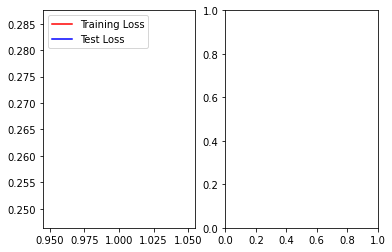

               precision    recall  f1-score   support

        toxic       0.59      0.16      0.26      6090
 severe_toxic       0.21      0.25      0.23       367
      obscene       0.62      0.14      0.23      3691
       threat       0.07      0.07      0.07       211
       insult       0.60      0.14      0.23      3427
identity_hate       0.21      0.07      0.11       712

    micro avg       0.51      0.15      0.23     14498
    macro avg       0.38      0.14      0.19     14498
 weighted avg       0.57      0.15      0.23     14498
  samples avg       0.01      0.01      0.01     14498

Epoch: 1 Train_Loss: 0.21169278505616462 Train_Accuracy: 0.964012861251831
Epoch: 1 Test_Loss: 0.21804924049973487 Test_Accuracy: 0.9625001549720764


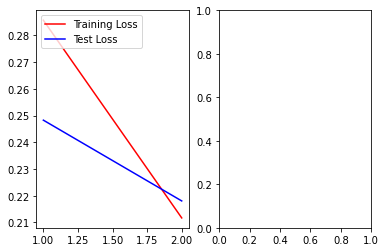

               precision    recall  f1-score   support

        toxic       0.75      0.19      0.30      6090
 severe_toxic       0.23      0.47      0.31       367
      obscene       0.75      0.18      0.29      3691
       threat       0.11      0.15      0.13       211
       insult       0.70      0.19      0.30      3427
identity_hate       0.24      0.11      0.15       712

    micro avg       0.58      0.19      0.29     14498
    macro avg       0.46      0.22      0.25     14498
 weighted avg       0.69      0.19      0.29     14498
  samples avg       0.01      0.01      0.01     14498

Epoch: 2 Train_Loss: 0.18283230860311633 Train_Accuracy: 0.9665467739105225
Epoch: 2 Test_Loss: 0.20633593052625657 Test_Accuracy: 0.9642872214317322


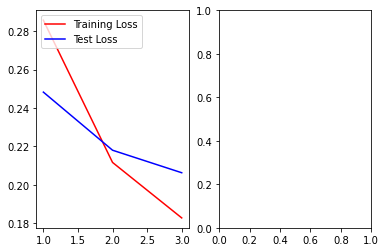

               precision    recall  f1-score   support

        toxic       0.69      0.25      0.37      6090
 severe_toxic       0.26      0.40      0.32       367
      obscene       0.73      0.25      0.37      3691
       threat       0.10      0.29      0.15       211
       insult       0.66      0.26      0.38      3427
identity_hate       0.25      0.12      0.16       712

    micro avg       0.57      0.25      0.35     14498
    macro avg       0.45      0.26      0.29     14498
 weighted avg       0.65      0.25      0.36     14498
  samples avg       0.02      0.02      0.02     14498

Epoch: 3 Train_Loss: 0.16986947119809115 Train_Accuracy: 0.968020498752594
Epoch: 3 Test_Loss: 0.1972203458249569 Test_Accuracy: 0.9646910429000854


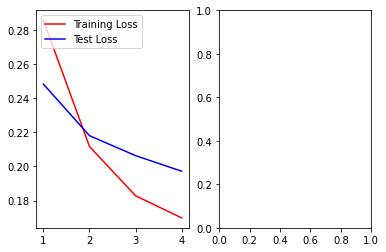

               precision    recall  f1-score   support

        toxic       0.74      0.26      0.39      6090
 severe_toxic       0.24      0.51      0.33       367
      obscene       0.74      0.28      0.41      3691
       threat       0.22      0.16      0.19       211
       insult       0.69      0.27      0.39      3427
identity_hate       0.25      0.19      0.21       712

    micro avg       0.61      0.27      0.37     14498
    macro avg       0.48      0.28      0.32     14498
 weighted avg       0.68      0.27      0.38     14498
  samples avg       0.02      0.02      0.02     14498

Epoch: 4 Train_Loss: 0.16144599361966053 Train_Accuracy: 0.9691986441612244
Epoch: 4 Test_Loss: 0.1958619335591793 Test_Accuracy: 0.9659727215766907


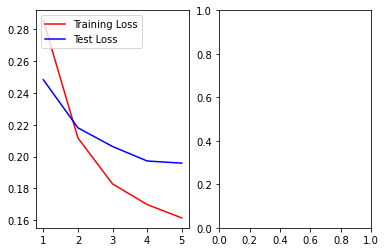

               precision    recall  f1-score   support

        toxic       0.66      0.34      0.45      6090
 severe_toxic       0.22      0.57      0.32       367
      obscene       0.68      0.38      0.48      3691
       threat       0.18      0.33      0.23       211
       insult       0.63      0.36      0.46      3427
identity_hate       0.25      0.20      0.23       712

    micro avg       0.57      0.35      0.43     14498
    macro avg       0.44      0.36      0.36     14498
 weighted avg       0.62      0.35      0.44     14498
  samples avg       0.03      0.03      0.02     14498

Epoch: 5 Train_Loss: 0.15343500920929587 Train_Accuracy: 0.9703601002693176
Epoch: 5 Test_Loss: 0.18466567614674567 Test_Accuracy: 0.9653344750404358


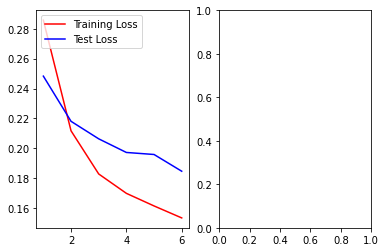

               precision    recall  f1-score   support

        toxic       0.78      0.28      0.41      6090
 severe_toxic       0.27      0.51      0.35       367
      obscene       0.78      0.31      0.45      3691
       threat       0.15      0.41      0.23       211
       insult       0.73      0.28      0.40      3427
identity_hate       0.27      0.16      0.20       712

    micro avg       0.63      0.29      0.40     14498
    macro avg       0.50      0.33      0.34     14498
 weighted avg       0.72      0.29      0.40     14498
  samples avg       0.02      0.02      0.02     14498

Epoch: 6 Train_Loss: 0.14766655997253764 Train_Accuracy: 0.9712437391281128
Epoch: 6 Test_Loss: 0.18880696111917497 Test_Accuracy: 0.9667672514915466


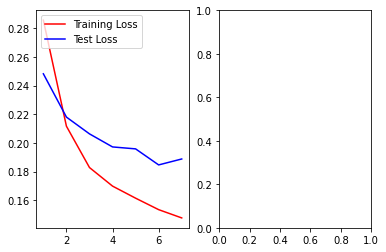

               precision    recall  f1-score   support

        toxic       0.73      0.36      0.48      6090
 severe_toxic       0.22      0.59      0.32       367
      obscene       0.74      0.39      0.51      3691
       threat       0.18      0.54      0.26       211
       insult       0.69      0.36      0.47      3427
identity_hate       0.25      0.19      0.22       712

    micro avg       0.60      0.37      0.45     14498
    macro avg       0.47      0.40      0.38     14498
 weighted avg       0.68      0.37      0.47     14498
  samples avg       0.03      0.03      0.03     14498

Epoch: 7 Train_Loss: 0.14214728075939304 Train_Accuracy: 0.9721221327781677
Epoch: 7 Test_Loss: 0.17761254441738128 Test_Accuracy: 0.9667229652404785


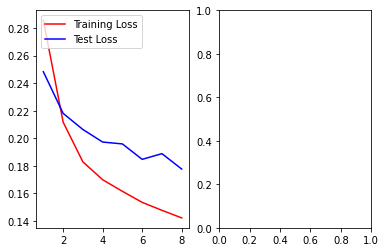

In [ ]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
for cls in classes:
    w = len(df) /df[cls].sum()
    weights.append(w)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(weight_set))
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((175796 - 35098*2) / 35098*2))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.0001)

epochs = 50

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e % 3000 == 0 and e != 0:
        torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(e))

    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=classes)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()





In [ ]:
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {} Recall: {} Precision: {}'.format(e, test_loss, accuracy, recall_score, precision_score))
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")


        ax2.plot(epoch_count, recalls, 'g', label='Recall')
        ax2.legend(loc="upper left")

        plt.show()

In [ ]:
probs = torch.sigmoid(logits)
print(probs)